In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [36]:
!pip install -qU sentence_transformers
!pip install -qU FlagEmbedding peft

['\n机器学习是一种让计算机通过数据进行学习的技术。近年来，随着大数据和计算能力的', '提升，机器学习在各个领域取得了显著的成果。\n自然语言处理是机器学习的一个', '重要应用领域。它涉及到计算机和人类语言之间的互动，如文本分析、语音识别和', '机器翻译等。\n通过使用深度学习模型，尤其是神经网络，自然语言处理的性能', '得到了极大的提升。\n例如，BERT模型在多个语言理解任务中表现出色，成为', '自然语言处理的一个重要里程碑。\n除了文本分类和情感分析，机器学习还在自动摘要、', '问答系统和对话系统等方面展现了强大的能力。\n尽管如此，机器学习在自然', '语言处理中的应用仍面临诸多挑战，如数据稀缺、多语言处理和模型的', '可解释性等。\n未来，随着技术的不断进步，机器学习将进一步推动自然语言', '处理的发展，带来更多创新的应用。']
分片总数 10


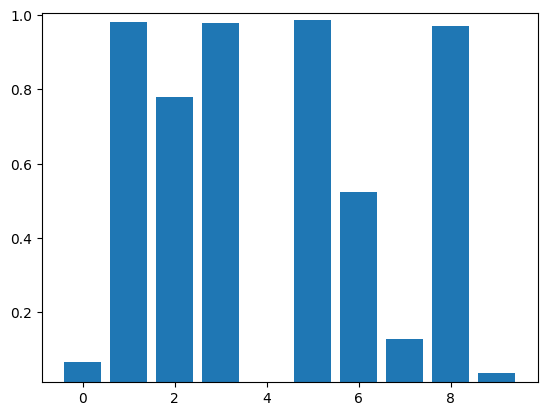

查询相似度 [0.06619351113437807, 0.9816358081976042, 0.7808551442360628, 0.9784751837609449, 0.011573140039222064, 0.9871043761067555, 0.5235065407428291, 0.12909138469903159, 0.9716795884009499, 0.036341914738822395]
整体查询相似度 0.5466456592056601
calculate_log:
[2.06454822e+00 2.10803437e-09 5.70511579e-04 4.67104215e-09
 4.25620254e+00 3.58944418e-10 3.33633879e-02 1.17776321e+00
 1.84808239e-08 2.85855828e+00]
10.391006172223374


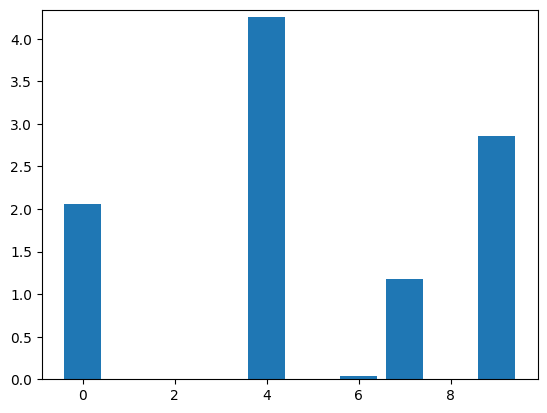


Iteration 1
Mean: 1.0391006172223374, Std: 1.453957135954903, Threshold: 2.1295684691885146
Updated best_start: 0, best_end: 9

Iteration 2
Mean: 0.8369386552092064, Std: 1.3929051268757993, Threshold: 1.8816175003660558
Updated best_start: 1, best_end: 9

Iteration 3
Mean: 0.6834874597859513, Std: 1.403845559399275, Threshold: 1.7363716293354075
Updated best_start: 1, best_end: 9
Converged.


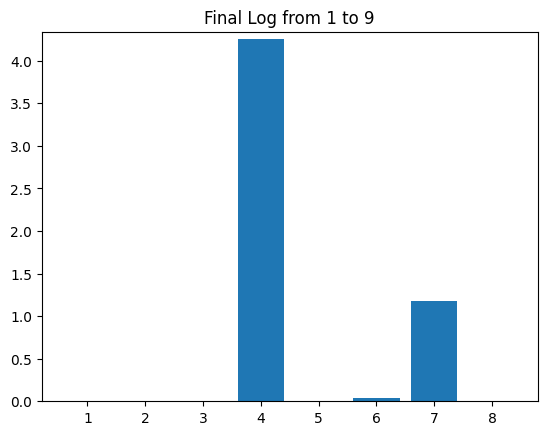

1 9
最优边界： 1 9
最优边界： 1 9
压缩后的文本:
提升，机器学习在各个领域取得了显著的成果。
自然语言处理是机器学习的一个重要应用领域。它涉及到计算机和人类语言之间的互动，如文本分析、语音识别和机器翻译等。
通过使用深度学习模型，尤其是神经网络，自然语言处理的性能得到了极大的提升。
例如，BERT模型在多个语言理解任务中表现出色，成为自然语言处理的一个重要里程碑。
除了文本分类和情感分析，机器学习还在自动摘要、问答系统和对话系统等方面展现了强大的能力。
尽管如此，机器学习在自然语言处理中的应用仍面临诸多挑战，如数据稀缺、多语言处理和模型的可解释性等。
未来，随着技术的不断进步，机器学习将进一步推动自然语言

压缩信息:
{'original_length': 337, 'compressed_length': 281, 'compression_ratio': 0.8338278931750742, 'overall_similarity': 0.5466456592056601}


In [37]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pylab as plt
from FlagEmbedding import FlagReranker

class OptimizedTextCompression:
    def __init__(self, model_name='BAAI/bge-reranker-v2-m3'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.reranker = FlagReranker(model_name, use_fp16=True)  # 初始化 reranker


    def compute_similarity(self, query, chunks):
        # 使用 reranker 计算相似度分数
        scores = self.reranker.compute_score([[query, chunk] for chunk in chunks], normalize=True)
        return scores

    def chunk_by_tokens(self, input_text: str, chunk_size: int = 20):
        tokens = self.tokenizer(input_text, return_offsets_mapping=True, add_special_tokens=False)
        token_offsets = tokens['offset_mapping']
        
        chunks = []
        span_annotations = []
        
        for i in range(0, len(token_offsets), chunk_size):
            chunk_end = min(i + chunk_size, len(token_offsets))
            if chunk_end - i > 0:
                start_offset = token_offsets[i][0]
                end_offset = token_offsets[chunk_end - 1][1]
                chunks.append(input_text[start_offset:end_offset])
                span_annotations.append((i, chunk_end))
        
        return chunks, span_annotations

    def calculate_log(self, similarities):
        similarities = np.clip(similarities, 1e-10, 1.-1e-10)
        focal_log = - (1 - similarities) ** 4 * np.log(similarities)
        print("calculate_log:")
        print(focal_log)
        print(sum(focal_log))
        plt.bar(range(len(focal_log)), focal_log)
        plt.ylim(min(focal_log) * 0.98, max(focal_log) * 1.02)
        plt.show()

        l = len(focal_log)
        best_start = 0
        best_end = l
        max_iterations=5
        tol=1e-5
        iteration = 0
        while iteration < max_iterations:
            iteration += 1
            print(f"\nIteration {iteration}")

            # 计算当前区间的均值和标准差
            current_focal_log = focal_log[best_start:best_end]
            mean = np.mean(current_focal_log)
            std = np.std(current_focal_log)
            threshold_stats = mean + 0.75 * std
            print(f"Mean: {mean}, Std: {std}, Threshold: {threshold_stats}")

            prev_best_start, prev_best_end = best_start, best_end

            # 重新确定 best_start
            new_best_start = best_start
            for i in range(best_start, best_end - 2):
                window1 = focal_log[i]
                window2 = np.mean(focal_log[i:i + 1])
                window3 = np.mean(focal_log[i:i + 2])
                if max(window1, window2, window3) > threshold_stats:
                    new_best_start = i + 1
                else:
                    break
            best_start = new_best_start

            # 重新确定 best_end
            new_best_end = best_end
            for i in range(1, best_end - best_start - 1):
                idx = best_end - i
                window1 = focal_log[idx]
                window2 = np.mean(focal_log[idx-1:idx])
                window3 = np.mean(focal_log[idx-2:idx])
                if max(window1, window2, window3) > threshold_stats:
                    new_best_end = idx
                else:
                    break
            best_end = new_best_end

            print(f"Updated best_start: {best_start}, best_end: {best_end}")

            # 检查是否收敛
            if (best_start == prev_best_start) and (best_end == prev_best_end):
                print("Converged.")
                break
        else:
            print("Reached maximum iterations without convergence.")

        # 最终绘制结果
        plt.bar(range(best_start, best_end), focal_log[best_start:best_end])
        plt.ylim(min(focal_log[best_start:best_end]) * 0.98, max(focal_log[best_start:best_end]) * 1.02)
        plt.title(f"Final Log from {best_start} to {best_end}")
        plt.show()

        print(best_start, best_end)
        return best_start, best_end

    def naive_chunking(self, chunks):
        outputs = []
        for chunk in chunks:
            outputs.append(self.encode(chunk))
        return outputs

    def optimize_boundaries(self, chunks, similarities, start, end):
        while start > 0 and similarities[start - 1] > similarities[start]:
            start -= 1
        while end < len(chunks) - 1 and similarities[end + 1] > similarities[end]:
            end += 1
        return start, end

    def compress_text(self, query, text, chunk_size=20):
        chunks, span_annotations = self.chunk_by_tokens(text, chunk_size)
        print(chunks)
        print("分片总数", len(chunks))
        
        # 使用 reranker 计算 chunk_embeddings 的相似度
        # similarities = [self.compute_similarity(query, chunk) for chunk in chunks]
        similarities = self.compute_similarity(query, chunks)
        plt.bar(range(len(similarities)), similarities)
        plt.ylim(min(similarities) * 0.98, max(similarities) * 1.02)
        plt.show()
        
        print("查询相似度", similarities)
        overall_similarity = np.mean(similarities)
        print("整体查询相似度", overall_similarity)
        
        best_start, best_end = self.calculate_log(similarities)
        print("最优边界：", best_start, best_end)
        best_start, best_end = self.optimize_boundaries(chunks, similarities, best_start, best_end)
        print("最优边界：", best_start, best_end)
        

        # 选择最佳的连续片段
        selected_chunks = chunks[best_start:best_end]
        
        compressed_text = ''.join(selected_chunks)
        
        compression_info = {
            'original_length': len(text),
            'compressed_length': len(compressed_text),
            'compression_ratio': len(compressed_text) / len(text),
            'overall_similarity': overall_similarity,
        }

        return compressed_text, compression_info

# 使用示例
compressor = OptimizedTextCompression(model_name='BAAI/bge-reranker-v2-m3')

query = "机器学习在自然语言处理中的应用"
text = """
机器学习是一种让计算机通过数据进行学习的技术。近年来，随着大数据和计算能力的提升，机器学习在各个领域取得了显著的成果。
自然语言处理是机器学习的一个重要应用领域。它涉及到计算机和人类语言之间的互动，如文本分析、语音识别和机器翻译等。
通过使用深度学习模型，尤其是神经网络，自然语言处理的性能得到了极大的提升。
例如，BERT模型在多个语言理解任务中表现出色，成为自然语言处理的一个重要里程碑。
除了文本分类和情感分析，机器学习还在自动摘要、问答系统和对话系统等方面展现了强大的能力。
尽管如此，机器学习在自然语言处理中的应用仍面临诸多挑战，如数据稀缺、多语言处理和模型的可解释性等。
未来，随着技术的不断进步，机器学习将进一步推动自然语言处理的发展，带来更多创新的应用。
"""


compressed_text, compression_info = compressor.compress_text(query, text)

print("压缩后的文本:")
print(compressed_text)
print("\n压缩信息:")
print(compression_info)

['\n机器学习是一种让计算机通过数据进行学习的技术。近年来，随着大数据和计算能力的', '提升，机器学习在各个领域取得了显著的成果。\n自然语言处理是机器学习的一个', '重要应用领域。它涉及到计算机和人类语言之间的互动，如文本分析、语音识别和', '机器翻译等。\n通过使用深度学习模型，尤其是神经网络，自然语言处理的性能', '得到了极大的提升。\n例如，BERT模型在多个语言理解任务中表现出色，成为', '自然语言处理的一个重要里程碑。\n除了文本分类和情感分析，机器学习还在自动摘要、', '问答系统和对话系统等方面展现了强大的能力。\n尽管如此，机器学习在自然', '语言处理中的应用仍面临诸多挑战，如数据稀缺、多语言处理和模型的', '可解释性等。\n未来，随着技术的不断进步，机器学习将进一步推动自然语言', '处理的发展，带来更多创新的应用。\n二、非选择题阅读材料，完成13～14', '题。●材料一：《尚书·禹贡》号称夏朝的古文献', '，这一先秦文献将当时认识到的黄河与长江流域分为九个大的区域', '即“九州”，简要叙述了各区域的物产、土壤、山川及', '族群情况，其中冀、兖、青、徐、豫、雍六州属黄河', '流域，扬、荆、梁三州属长江流域。该文献根据适合农业', '与否，将各地土壤分为上上至下下九个等级，总体上黄河', '流域各区域更适合农业生产，并称以渭河平原为中心的雍州', '“厥土惟黄壤，厥田惟上上”，而今江浙一带的', '扬州，“厥土惟涂泥，厥田唯下下”。司马迁在', '《史记·货殖列传》中，分叙汉武帝时全国各地的社会经济', '与人文情况，说：“关中自?、雍以东至河、华，膏', '壤沃野千里，自虞夏之贡以为上田……故关中之地，', '于天下三分之一，而人众不过什三。然量其富，什居其六', '”；而长江中下游以南，“地广人稀，饭稻羹鱼，', '或火耕而水耨……江淮以南，无冻饿之人，亦无', '千金之家。 ”●材料二：两汉时期，长江流域社会经济发展迅速。', '比较《汉书》所记西汉元始二年(公元2年)及', '《续汉书·郡国志》所记东汉永和五年 (公元140', '年)的人口记录可知，在近一个半世纪中，全国总人口呈负', '增长，而长江流域各地区户数与口数都有不同程度的增长，甚至', '异常的增长。其中包括浙江、福建二省及江苏、安徽二省长江以南地

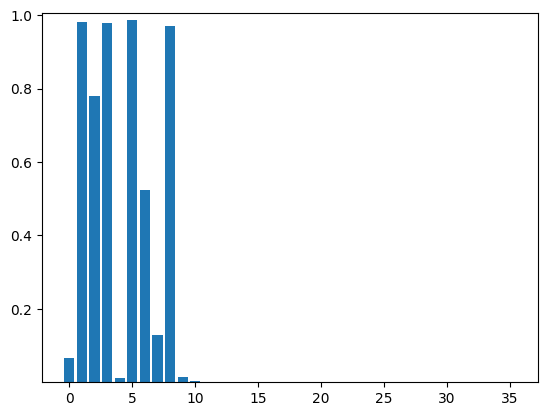

查询相似度 [0.06619351113437807, 0.9816358081976042, 0.7808551442360628, 0.9784751837609449, 0.011573140039222064, 0.9871043761067555, 0.5235065407428291, 0.12909138469903159, 0.9716795884009499, 0.01509478700429746, 0.002917361246229362, 1.7102419055150636e-05, 0.0005672137738293908, 5.9424396799463627e-05, 1.605514810138381e-05, 0.0005343158516950255, 1.5990969940126342e-05, 0.0003071304884154792, 2.3789416855454515e-05, 1.7197917958187356e-05, 0.00019417316352473942, 0.00012470234667628723, 2.4068409103612678e-05, 0.00036463229374821866, 0.00012516946772310223, 1.844053484244543e-05, 3.969559593339641e-05, 5.6465939060926285e-05, 1.6583309375710895e-05, 3.6666034804902434e-05, 9.929579391540141e-05, 2.5706846507717432e-05, 6.492109994184893e-05, 1.7736012762784144e-05, 1.6494447646770463e-05, 1.709072888344689e-05]
整体查询相似度 0.15141463577709463
calculate_log:
[2.06454822e+00 2.10803437e-09 5.70511579e-04 4.67104215e-09
 4.25620254e+00 3.58944418e-10 3.33633879e-02 1.17776321e+00
 1.8480823

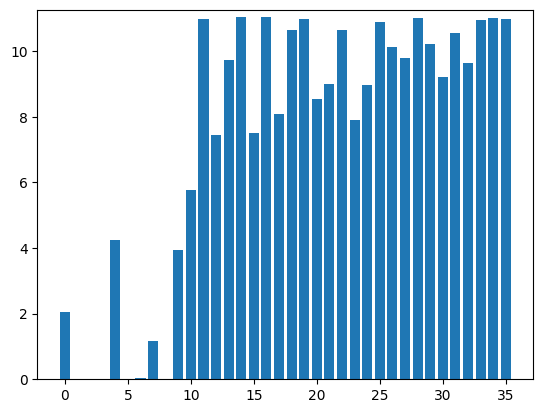


Iteration 1
Mean: 7.3368777159916725, Std: 4.109823169220764, Threshold: 10.419245092907246
Updated best_start: 0, best_end: 25

Iteration 2
Mean: 5.989928118222074, Std: 4.268504351213042, Threshold: 9.191306381631854
Updated best_start: 0, best_end: 11

Iteration 3
Mean: 1.5679629695969866, Std: 2.035517178494813, Threshold: 3.0946008534680964
Updated best_start: 0, best_end: 9

Iteration 4
Mean: 0.8369386552092064, Std: 1.3929051268757993, Threshold: 1.8816175003660558
Updated best_start: 1, best_end: 9

Iteration 5
Mean: 0.6834874597859513, Std: 1.403845559399275, Threshold: 1.7363716293354075
Updated best_start: 1, best_end: 9
Converged.


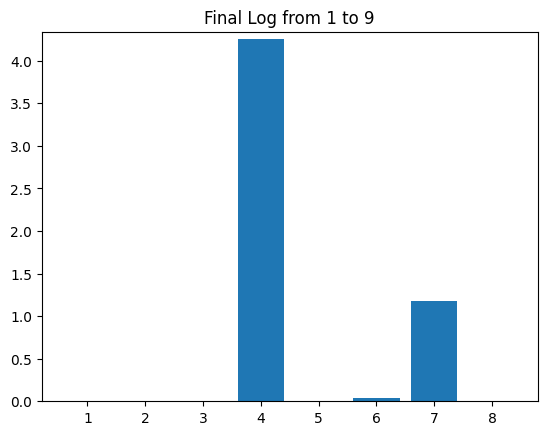

1 9
最优边界： 1 9
最优边界： 1 9
压缩后的文本:
提升，机器学习在各个领域取得了显著的成果。
自然语言处理是机器学习的一个重要应用领域。它涉及到计算机和人类语言之间的互动，如文本分析、语音识别和机器翻译等。
通过使用深度学习模型，尤其是神经网络，自然语言处理的性能得到了极大的提升。
例如，BERT模型在多个语言理解任务中表现出色，成为自然语言处理的一个重要里程碑。
除了文本分类和情感分析，机器学习还在自动摘要、问答系统和对话系统等方面展现了强大的能力。
尽管如此，机器学习在自然语言处理中的应用仍面临诸多挑战，如数据稀缺、多语言处理和模型的可解释性等。
未来，随着技术的不断进步，机器学习将进一步推动自然语言

压缩信息:
{'original_length': 997, 'compressed_length': 281, 'compression_ratio': 0.2818455366098295, 'overall_similarity': 0.15141463577709463}


In [38]:
text += """二、非选择题阅读材料，完成13～14题。●材料一：《尚书·禹贡》号称夏朝的古文献，这一先秦文献将当时认识到的黄河与长江流域分为九个大的区域即“九州”，简要叙述了各区域的物产、土壤、山川及族群情况，其中冀、兖、青、徐、豫、雍六州属黄河流域，扬、荆、梁三州属长江流域。该文献根据适合农业与否，将各地土壤分为上上至下下九个等级，总体上黄河流域各区域更适合农业生产，并称以渭河平原为中心的雍州“厥土惟黄壤，厥田惟上上”，而今江浙一带的扬州，“厥土惟涂泥，厥田唯下下”。司马迁在《史记·货殖列传》中，分叙汉武帝时全国各地的社会经济与人文情况，说：“关中自?、雍以东至河、华，膏壤沃野千里，自虞夏之贡以为上田……故关中之地，于天下三分之一，而人众不过什三。然量其富，什居其六”；而长江中下游以南，“地广人稀，饭稻羹鱼，或火耕而水耨……江淮以南，无冻饿之人，亦无千金之家。 ”●材料二：两汉时期，长江流域社会经济发展迅速。比较《汉书》所记西汉元始二年(公元2年)及《续汉书·郡国志》所记东汉永和五年 (公元140年)的人口记录可知，在近一个半世纪中，全国总人口呈负增长，而长江流域各地区户数与口数都有不同程度的增长，甚至异常的增长。其中包括浙江、福建二省及江苏、安徽二省长江以南地区的会稽、丹阳、吴郡，户数增长28.11%，口数增长26.05%；与今江西省大体 相 当 的 豫 章 郡 户 数 增 长502.70%，口数增长374.16%；荆州长江以南的长沙、零陵、桂阳、武陵四郡大体上与今湖南省相当，户数增 长 达 412.25% """


compressed_text, compression_info = compressor.compress_text(query, text)

print("压缩后的文本:")
print(compressed_text)
print("\n压缩信息:")
print(compression_info)